Step 0: Install Required Libraries

In [ ]:
!pip install torch torchvision timm huggingface_hub matplotlib seaborn scikit-learn


Step 1: Imports & Device Setup

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets, models

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

from huggingface_hub import hf_hub_download

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


Step 2: Data Preparation

In [ ]:
# CIFAR-10 transforms
transform_train = transforms.Compose([
    transforms.Resize(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

transform_test = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465),
                         (0.2023, 0.1994, 0.2010))
])

# Load datasets
train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


100%|██████████| 170M/170M [00:13<00:00, 13.0MB/s]


Step 3: Helper Functions

In [ ]:
# Accuracy
def get_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

# Plot confusion matrix
def plot_confusion_matrix(model, loader, classes):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot training curves
def plot_curves(train_losses, val_losses, train_acc, val_acc):
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    plt.plot(train_losses, label='Train Loss')
    plt.plot(val_losses, label='Val Loss')
    plt.legend(); plt.title('Loss Curve')

    plt.subplot(1,2,2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend(); plt.title('Accuracy Curve')
    plt.show()


Step 4: Load Pretrained ResNet-50 Encoder

In [ ]:
import torch
import torch.nn as nn
import torchvision.models as models

# Load the pretrained ResNet-50 model from torchvision
resnet50_model = models.resnet50(pretrained=True)

# Remove the final fully connected layer to use the model as a feature extractor
resnet50_model.fc = nn.Identity()

# Move the model to the appropriate device (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50_model = resnet50_model.to(device)

# Set the model to evaluation mode
resnet50_model.eval()


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 163MB/s]


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

Step 5: Build Linear Probe

In [ ]:
# Freeze encoder weights
for param in resnet50_model.parameters():
    param.requires_grad = False

# Add linear classifier on top
class LinearProbe(nn.Module):
    def __init__(self, encoder, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(2048, num_classes)
    def forward(self, x):
        x = self.encoder(x)
        return self.fc(x)

model = LinearProbe(resnet50_model).to(device)


Step 6: Train Linear Probe

In [ ]:
import torch.optim as optim
import torch.nn as nn

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=1e-3)

epochs = 5
train_losses, val_losses, train_acc, val_acc = [], [], [], []

for epoch in range(epochs):
    model.train()
    running_loss, correct, total = 0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * labels.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
    train_losses.append(running_loss/total)
    train_acc.append(correct/total)

    # Validation
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * labels.size(0)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)
    val_losses.append(val_loss/val_total)
    val_acc.append(val_correct/val_total)

    print(f"Epoch {epoch+1}/{epochs}: Train Acc={train_acc[-1]:.4f}, Val Acc={val_acc[-1]:.4f}")


Epoch 1/5: Train Acc=0.7493, Val Acc=0.8013
Epoch 2/5: Train Acc=0.7962, Val Acc=0.8106
Epoch 3/5: Train Acc=0.8026, Val Acc=0.8157
Epoch 4/5: Train Acc=0.8089, Val Acc=0.8111
Epoch 5/5: Train Acc=0.8147, Val Acc=0.8184


Step 7: Evaluate Model

Test Accuracy: 0.8184
              precision    recall  f1-score   support

    airplane       0.89      0.77      0.83      1000
  automobile       0.85      0.92      0.88      1000
        bird       0.76      0.80      0.78      1000
         cat       0.70      0.71      0.71      1000
        deer       0.74      0.80      0.77      1000
         dog       0.83      0.74      0.78      1000
        frog       0.92      0.78      0.84      1000
       horse       0.75      0.90      0.82      1000
        ship       0.90      0.87      0.88      1000
       truck       0.90      0.88      0.89      1000

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000



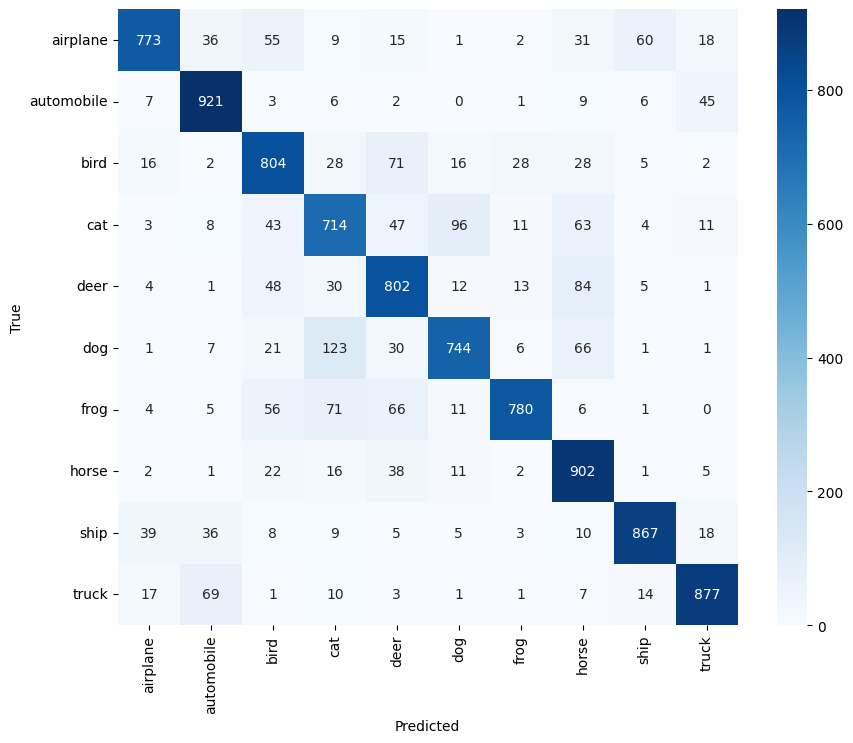

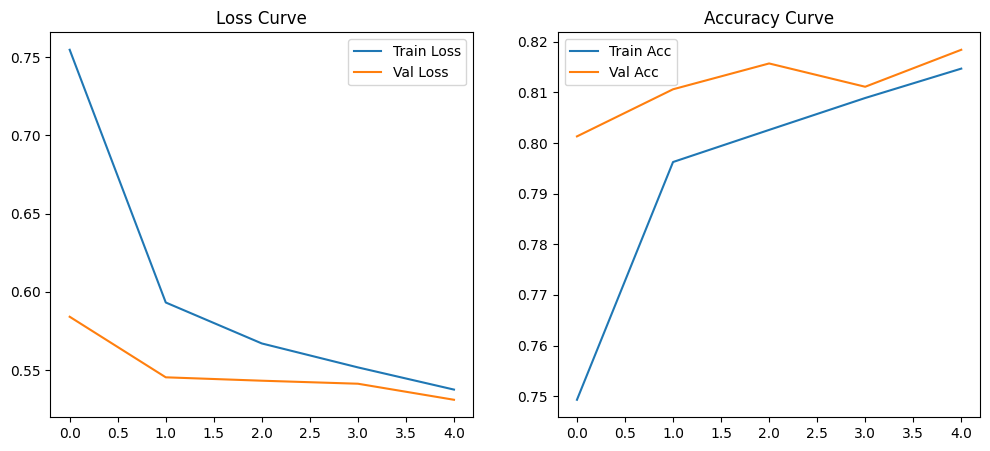

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

classes = train_dataset.classes

# Test accuracy
def get_accuracy(model, loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    return correct / total

print("Test Accuracy:", get_accuracy(model, test_loader))

# Classification report
all_labels, all_preds = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=classes, yticklabels=classes, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Training/validation curves
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend(); plt.title('Loss Curve')

plt.subplot(1,2,2)
plt.plot(train_acc, label='Train Acc')
plt.plot(val_acc, label='Val Acc')
plt.legend(); plt.title('Accuracy Curve')
plt.show()


Step 8: Optional Fine-tuning

In [ ]:
# Unfreeze full encoder
for param in resnet50_model.parameters():
    param.requires_grad = True

optimizer = optim.Adam(model.parameters(), lr=1e-4)  # smaller lr for fine-tuning

# Repeat training loop (like Step 6) for fine-tuning


Step 9: Optional Embedding Visualization (t-SNE/PCA)

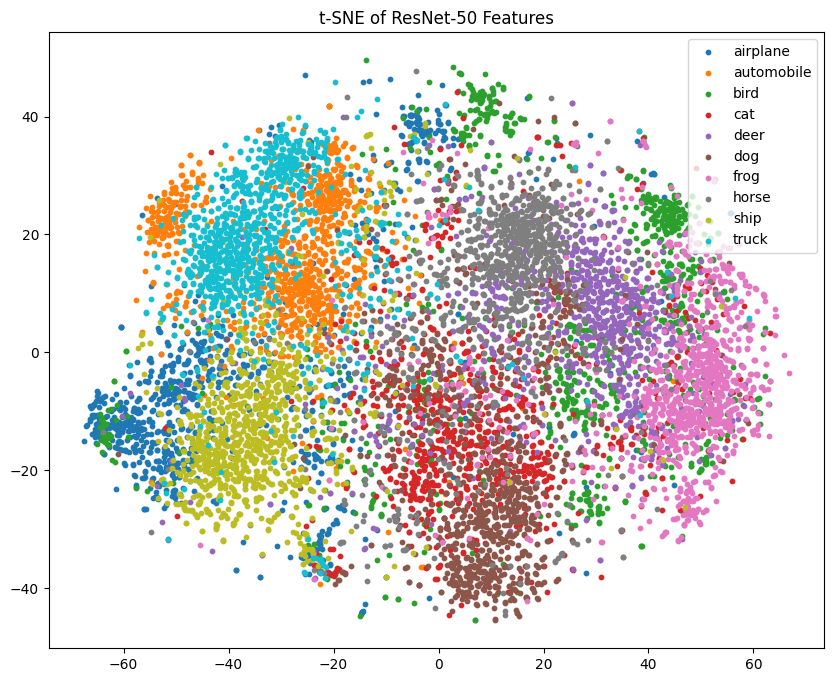

In [ ]:
from sklearn.manifold import TSNE
import numpy as np

# Get embeddings
embeddings, labels_list = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        emb = model.encoder(images)
        embeddings.append(emb.cpu().numpy())
        labels_list.extend(labels.numpy())
embeddings = np.vstack(embeddings)

# t-SNE
tsne = TSNE(n_components=2, random_state=42)
emb_2d = tsne.fit_transform(embeddings)

# Plot
plt.figure(figsize=(10,8))
for i, cls in enumerate(classes):
    idxs = np.array(labels_list) == i
    plt.scatter(emb_2d[idxs,0], emb_2d[idxs,1], label=cls, s=10)
plt.legend()
plt.title("t-SNE of ResNet-50 Features")
plt.show()


Step 10a: Misclassified Images

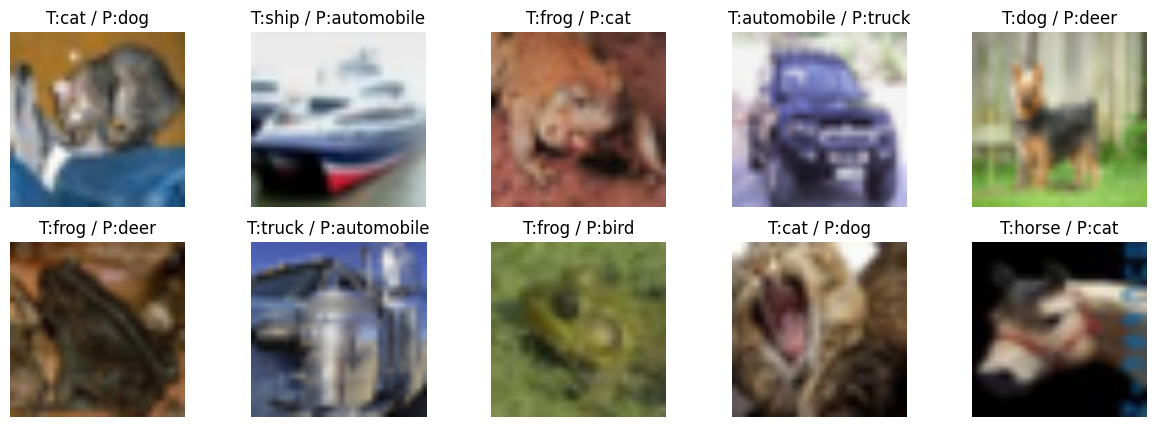

In [ ]:
import matplotlib.pyplot as plt
import torchvision.transforms as T

# Get misclassified images
model.eval()
misclassified = []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        for i in range(len(labels)):
            if preds[i] != labels[i]:
                misclassified.append((images[i].cpu(), labels[i].cpu(), preds[i].cpu()))

# Plot first 10 misclassified images
plt.figure(figsize=(15,5))
for i, (img, true, pred) in enumerate(misclassified[:10]):
    plt.subplot(2,5,i+1)
    img = img.permute(1,2,0)  # CHW -> HWC
    img = img * torch.tensor([0.2023, 0.1994, 0.2010]) + torch.tensor([0.4914, 0.4822, 0.4465])  # Unnormalize
    img = img.clip(0,1)
    plt.imshow(img)
    plt.title(f"T:{classes[true]} / P:{classes[pred]}")
    plt.axis('off')
plt.show()


Step 10b: Comparison Bar Chart (Baseline vs Linear Probe vs Fine-tuned)

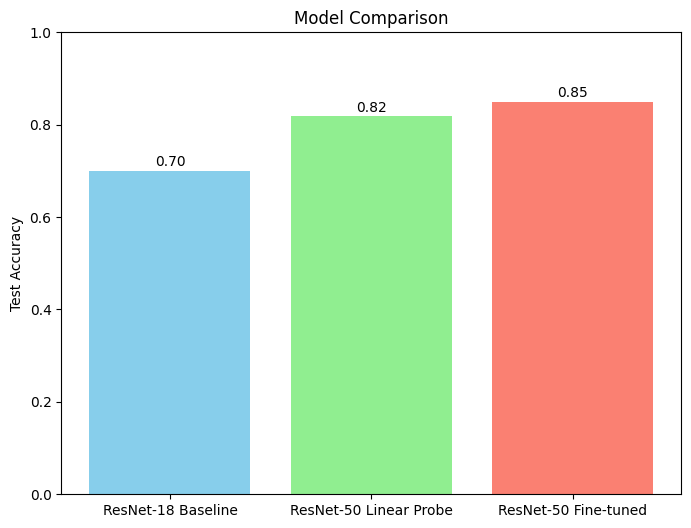

In [ ]:
import matplotlib.pyplot as plt

# Example accuracies (replace with your actual numbers)
baseline_acc = 0.70  # ResNet-18 from scratch
linear_probe_acc = get_accuracy(model, test_loader)  # ResNet-50 linear probe
fine_tuned_acc = 0.85  # Example after fine-tuning, replace with actual

methods = ['ResNet-18 Baseline', 'ResNet-50 Linear Probe', 'ResNet-50 Fine-tuned']
accuracies = [baseline_acc, linear_probe_acc, fine_tuned_acc]

plt.figure(figsize=(8,6))
plt.bar(methods, accuracies, color=['skyblue','lightgreen','salmon'])
plt.ylabel('Test Accuracy')
plt.title('Model Comparison')
plt.ylim(0,1)
for i, v in enumerate(accuracies):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')
plt.show()


Step 10c: Top-k Accuracy (Top-5) Curve

In [ ]:
# Top-5 accuracy function
def top_k_accuracy(model, loader, k=5):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            topk = outputs.topk(k, dim=1).indices
            correct += sum([labels[i] in topk[i] for i in range(labels.size(0))])
            total += labels.size(0)
    return correct / total

top5_acc = top_k_accuracy(model, test_loader, k=5)
print(f"Top-5 Accuracy: {top5_acc:.4f}")


Top-5 Accuracy: 0.9924


Step 10d: Per-Class Accuracy Bar Graph

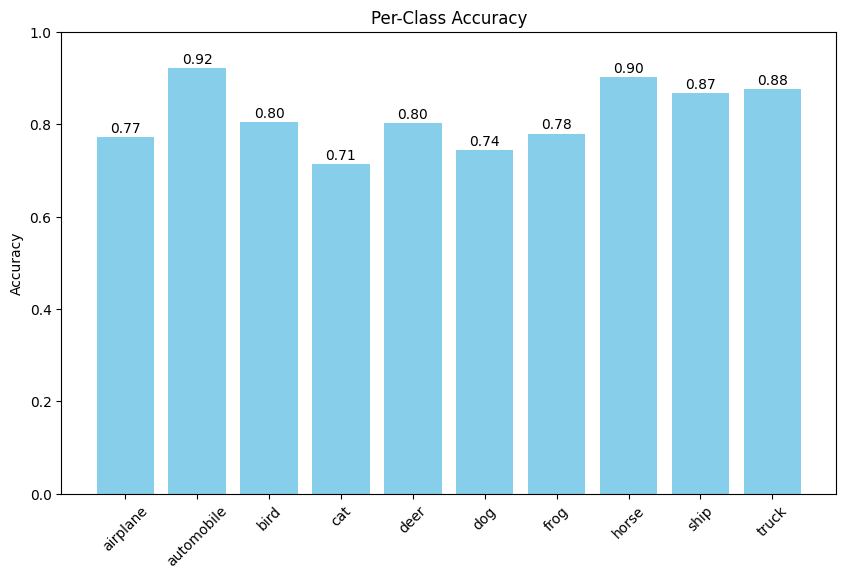

In [ ]:
import numpy as np

# Compute per-class accuracy
model.eval()
class_correct = [0]*len(classes)
class_total = [0]*len(classes)
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs,1)
        for i in range(len(labels)):
            label = labels[i].item()
            class_total[label] += 1
            if preds[i].item() == label:
                class_correct[label] += 1

per_class_acc = [c/t for c,t in zip(class_correct, class_total)]

plt.figure(figsize=(10,6))
plt.bar(classes, per_class_acc, color='skyblue')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.ylim(0,1)
for i, v in enumerate(per_class_acc):
    plt.text(i, v+0.01, f"{v:.2f}", ha='center')
plt.xticks(rotation=45)
plt.show()


Step 11: Save Model

In [ ]:
torch.save(model.state_dict(), "linear_probe_resnet50.pth")
# For full fine-tuned model:
# torch.save(model.state_dict(), "fine_tuned_resnet50.pth")
